This section of notebook, explores the data provided for the CW task - Face Emotion Recognition.
The following code has been adapted from here - https://www.datacamp.com/community/tutorials/diving-deep-imbalanced-data

https://amueller.github.io/ml-training-advanced/slides/04-imbalanced-data.html#1

https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html


https://imbalanced-learn.org/stable/auto_examples/applications/plot_over_sampling_benchmark_lfw.html

https://kiwidamien.github.io/how-to-do-cross-validation-when-upsampling-data.html

https://soph.info/2019/05/07/imbalance/

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/Face-Emotion-Recognition-Project' 
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['.gitignore', 'LICENSE', 'README.md', 'src', 'models', 'personal_dataset', '.git', '.vscode', '__pycache__', 'CW_Dataset', 'train_hog_naive_bayes.ipynb', 'train_function.ipynb', 'hyper-parameter-tuning and training models.ipynb', 'SVM-SIFT train dummy.ipynb', 'References .gdoc', '.ipynb_checkpoints', 'SVM-HOG train dummy.ipynb', 'Copy of SVM-SIFT train dummy.ipynb', 'train_sift_naive_bayes.ipynb', 'Copy of SVM-HOG train dummy.ipynb', 'MLP-HOG train .ipynb', 'SIFT_MLP.ipynb', 'Pre-trained CNN and MLP training.ipynb', 'Pre-trained CNN and SVM.ipynb', 'test_function.ipynb', 'Data Exploration and SIFT-SVM Models.ipynb']


In [3]:
import sys
modules_needed = ['models','models/feature_descriptors','models/lib']
for i in modules_needed:
  if i not in sys.path:
    CODE_PATH = os.path.join(GOOGLE_DRIVE_PATH,i )
    sys.path.append(CODE_PATH)

In [4]:
zip_path = os.path.join(GOOGLE_DRIVE_PATH,'CW_Dataset/CW_Dataset.zip')

# Copy it to Colab
!cp '{zip_path}' .

# Unzip it
!yes|unzip -q CW_Dataset.zip

# Delete zipped version from Colab (not from Drive)
!rm CW_Dataset.zip

In [5]:
CODE_PATH = os.path.join(GOOGLE_DRIVE_PATH, 'src')
sys.path.append(CODE_PATH)

In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
from data_loader import import_selected_data, shuffleData
from preprocessing import *
from collections import  Counter
import numpy as np

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [8]:
!pip install opencv-python==4.4.0.46

     |████████████████████████████████| 49.5MB 88kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30


In [9]:
import cv2

from skimage import img_as_ubyte, io, color

from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

%matplotlib inline

In [10]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV,StratifiedKFold, KFold
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC


In [11]:
X_train,y_train = import_selected_data('train')


In [12]:
Counter(y_train)

Counter({1: 1290, 2: 281, 3: 717, 4: 4772, 5: 1982, 6: 705, 7: 2524})

First looking at how much class imblance there is.

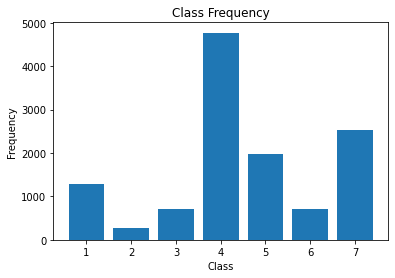

In [ ]:

unique, counts = np.unique(y_train, return_counts=True)

plt.bar(unique,counts)
plt.title('Class Frequency')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

1: Surprise
2: Fear
3: Disgust
4: Happiness
5: Sadness
6: Anger
7: Neutral

In [13]:
Counter(y_train)

Counter({1: 1290, 2: 281, 3: 717, 4: 4772, 5: 1982, 6: 705, 7: 2524})

**Establishing a baseline before trying to balance data**

In [14]:
X_train, y_train = shuffleData(X_train, y_train)

In [15]:
from sift import SIFT_DETECTOR

In [16]:
sift_obj = SIFT_DETECTOR()

In [18]:
sift_obj.identify_keypoints(X_train, y_train)

In [ ]:
sift_obj.show_SIFT_keypoints()

In [ ]:
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline


In [ ]:
import scipy
from time import time

Choosing the batch size manually to save CPU execution time ( if this was also hyper parameter tuned, it would take longer)

In [ ]:
batch_size = sift_obj.des_array.shape[0] // 32
batch_size

22374

In [ ]:
len(sift_obj.des_array)

715980

In [ ]:
len(sift_obj.y_list)

12264

In [ ]:
kmm_params= {'n_clusters': [70,75,80,90,100], 'batch_size': [batch_size]}

In [ ]:
kmm_cv = make_pipeline(
    preprocessing.StandardScaler(),
    GridSearchCV(estimator=MiniBatchKMeans(random_state=1, max_iter=400),
                 param_grid=kmm_params,
                 cv=5, n_jobs=-1))

In [ ]:
time_initial = time()
kmm_cv.fit(sift_obj.des_array)
print(f"done in {(time() - time_initial)}s")

done in 496.51609563827515s


In [ ]:
kmm_cv.steps[-1][1].best_params_

{'batch_size': 22374, 'n_clusters': 100}

In [ ]:
from joblib import load, dump

In [ ]:
filename = os.path.join(GOOGLE_DRIVE_PATH, 'models/lib/baseline_kmm.joblib')
dump(kmm_cv,filename)

['drive/My Drive/Colab Notebooks/Face-Emotion-Recognition-Project/models/lib/baseline_kmm.joblib']

In [ ]:
from bow import bag_of_visual_words
hist_array, hist_list, y_train = bag_of_visual_words(sift_obj.des_list, sift_obj.y_list,kmm_cv,100)

In [ ]:
len(hist_array) == len(y_train)

True

In [ ]:
svc_params = {
    "C": [0.001, 0.01, 0.1, 1, 10],
    "gamma": [0.001, 0.01, 0.1, 1],
    "kernel": ["rbf", "linear"],
}

In [ ]:
svc_cv = make_pipeline(
    preprocessing.StandardScaler(),
    GridSearchCV(estimator=SVC(random_state=1, max_iter=400),
                 param_grid=svc_params,
                 cv=StratifiedKFold(n_splits=3, shuffle=True), n_jobs=-1))

In [ ]:
time_initial = time()
predicted_SVC = svc_cv.fit(hist_array,y_train)
print(f"done in {(time() - time_initial)}s")

done in 706.1469025611877s


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=400).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


In [ ]:
predicted_SVC.steps[-1][1].best_params_

{'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}

In [ ]:
predicted_SVC.steps[-1][1].best_score_

0.3073222439660796

In [ ]:
filename = os.path.join(GOOGLE_DRIVE_PATH, 'models/lib/baseline_sift_svm.joblib')
dump(svc_cv,filename)

['drive/My Drive/Colab Notebooks/Face-Emotion-Recognition-Project/models/lib/baseline_sift_svm.joblib']

In [19]:
X_test, y_test = import_selected_data('test')

In [20]:
X_test.shape

(3068, 100, 100, 3)

In [21]:
#Adapted from LAB 07
def get_feature_descriptor(X_test, y_test, kmeans,k):
  hist_list = []
  sift = cv2.SIFT_create()
  for i in range(len(X_test)):
      img = img_as_ubyte(color.rgb2gray(X_test[i]))
      kp, des = sift.detectAndCompute(img, None)

      if des is not None:
          hist = np.zeros(k)

          idx = kmeans.predict(des)

          for j in idx:
              hist[j] = hist[j] + (1 / len(des))

          # hist = scale.transform(hist.reshape(1, -1))
          hist_list.append(hist)

      else:
          hist_list.append(None)

  # Remove potential cases of images with no descriptors
  idx_not_empty = [i for i, x in enumerate(hist_list) if x is not None]
  hist_list = [hist_list[i] for i in idx_not_empty]
  y_test = [y_test[i] for i in idx_not_empty]
  hist_array = np.vstack(hist_list)
  return hist_array, hist_list, y_test

In [23]:
from joblib import load

In [24]:
filename = os.path.join(GOOGLE_DRIVE_PATH, 'models/lib/baseline_kmm.joblib')

kmm_cv = load(filename)

In [29]:
filename = os.path.join(GOOGLE_DRIVE_PATH, 'models/lib/baseline_sift_svm.joblib')

predicted_SVC = load(filename)

In [27]:
test_hist_array, test_hist_list, y_test = get_feature_descriptor(X_test, y_test, kmm_cv, 100)

In [28]:
predicted_svm = predicted_SVC.predict(test_hist_array).tolist()

In [30]:
X_test, _ = import_selected_data('test')

In [31]:
idx_not_empty = [i for i, x in enumerate(test_hist_list) if x is not None]
X_test = [X_test[i] for i in idx_not_empty]

In [32]:
from sklearn.utils import shuffle
from sklearn.metrics import matthews_corrcoef

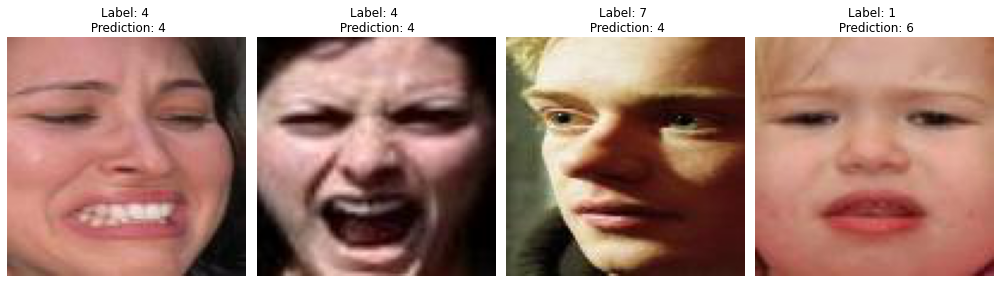

In [33]:
X_test, y_test, predicted = shuffle(X_test , y_test, predicted_svm)
#X_test_img = X_test.reshape(-1, 100, 100)


fig, axes = plt.subplots(1, 4, figsize=(14, 7), sharex=True, sharey=True)
ax = axes.ravel()

for i in range(4):
    ax[i].imshow(X_test[i])
    ax[i].set_title(f'Label: {y_test[i]} \n Prediction: {predicted[i]}')
    ax[i].set_axis_off()
fig.tight_layout()
plt.show()

In [34]:
print(f"""Classification report for classifier {predicted_SVC}:
      {metrics.classification_report(y_test, predicted)}\n""")

Classification report for classifier Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('gridsearchcv',
                 GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=True),
                              error_score=nan,
                              estimator=SVC(C=1.0, break_ties=False,
                                            cache_size=200, class_weight=None,
                                            coef0=0.0,
                                            decision_function_shape='ovr',
                                            degree=3, gamma='scale',
                                            kernel='rbf', max_iter=400,
                                            probability=False, random_state=1,
                                            shrinking=True, tol=0.001,
                                            verbose=False),
                          

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


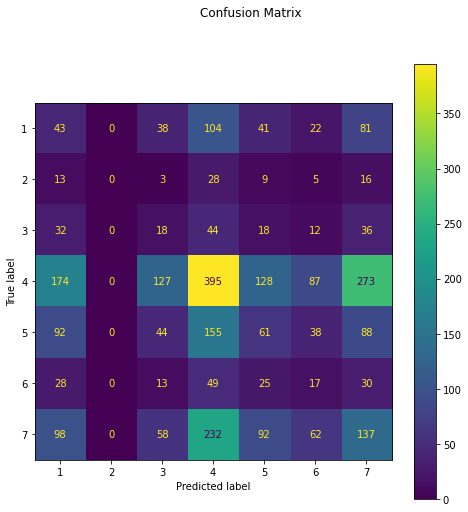

In [35]:
fig, ax = plt.subplots(figsize=(8, 8))
disp = metrics.plot_confusion_matrix(predicted_SVC, list(test_hist_array), y_test, values_format = 'd', ax=ax)
disp.figure_.suptitle("Confusion Matrix")
plt.show()

In [36]:
matthews_corrcoef(y_test, predicted)

0.07675613623602473

Creating a model which uses RandomOverSampling in the minority class

In [ ]:
X_train, y_train = import_selected_data('train')

In [ ]:
from imblearn.pipeline import make_pipeline, Pipeline


In [ ]:
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [ ]:
sift_obj_2 = SIFT_DETECTOR()

In [ ]:
sift_obj_2.identify_keypoints(X_train,y_train)

In [41]:
filename = os.path.join(GOOGLE_DRIVE_PATH, 'models/lib/baseline_kmm.joblib')
kmm_model = load(filename)

In [ ]:
from bow import bag_of_visual_words
hist_array, hist_list, y_train = bag_of_visual_words(sift_obj_2.des_list, sift_obj_2.y_list,kmm_model,100)

In [ ]:
len(hist_array) == len(y_train)

True

In [ ]:
model_oversample = make_pipeline(RandomOverSampler(), preprocessing.StandardScaler(), SVC(max_iter=400))

In [ ]:
svc_params = {
    "C": [0.1, 1, 10],
    "gamma": [0.01, 0.1, 1],
    "kernel": ["rbf", "linear"],
}

In [ ]:
new_params = {'svc__' + key: svc_params[key] for key in svc_params}

In [ ]:
grid_imba = GridSearchCV(model_oversample, param_grid= new_params, cv=5,
                        return_train_score=True)

In [ ]:
grid_imba.fit(hist_array,y_train)

In [ ]:
grid_imba.best_score_


0.2828602191011572

In [ ]:
grid_imba.best_params_

{'svc__C': 1, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}

In [ ]:
filename = os.path.join(GOOGLE_DRIVE_PATH, 'models/lib/trained_sift_bow_svm.joblib')
dump(grid_imba,filename)

['drive/My Drive/Colab Notebooks/Face-Emotion-Recognition-Project/models/lib/trained_sift_bow_svm.joblib']

In [ ]:
test = load(filename)

In [ ]:
test.best_score_

0.2828602191011572

In [43]:
filename = os.path.join(GOOGLE_DRIVE_PATH, 'models/lib/trained_sift_bow_svm.joblib')
grid_imba = load(filename)

In [38]:
X_test, y_test = import_selected_data('test')

In [42]:
test_hist_array, test_hist_list, y_test = get_feature_descriptor(X_test, y_test, kmm_model, 100)

In [44]:
predicted_svm = grid_imba.predict(test_hist_array).tolist()

In [45]:
idx_not_empty = [i for i, x in enumerate(test_hist_list) if x is not None]
X_test = [X_test[i] for i in idx_not_empty]

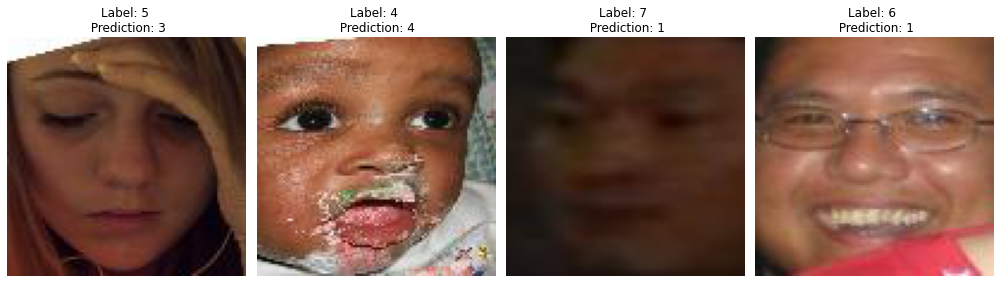

In [46]:
X_test, y_test, predicted = shuffle(X_test , y_test, predicted_svm)
#X_test_img = X_test.reshape(-1, 100, 100)


fig, axes = plt.subplots(1, 4, figsize=(14, 7), sharex=True, sharey=True)
ax = axes.ravel()

for i in range(4):
    ax[i].imshow(X_test[i])
    ax[i].set_title(f'Label: {y_test[i]} \n Prediction: {predicted[i]}')
    ax[i].set_axis_off()
fig.tight_layout()
plt.show()

In [47]:
print(f"""Classification report for classifier {predicted_svm}:
      {metrics.classification_report(y_test, predicted)}\n""")

Classification report for classifier [6, 5, 1, 4, 7, 4, 7, 7, 5, 6, 4, 4, 4, 7, 4, 1, 6, 4, 4, 2, 1, 1, 4, 4, 7, 4, 4, 5, 4, 4, 1, 7, 7, 6, 7, 4, 7, 4, 1, 4, 7, 7, 4, 6, 7, 6, 7, 4, 7, 4, 6, 4, 4, 2, 4, 7, 1, 4, 5, 7, 1, 3, 5, 4, 7, 5, 1, 4, 4, 4, 7, 4, 7, 4, 5, 2, 4, 4, 1, 5, 2, 5, 4, 7, 7, 1, 4, 4, 1, 1, 1, 4, 6, 7, 4, 1, 4, 1, 1, 7, 5, 1, 7, 7, 6, 7, 1, 7, 4, 4, 1, 7, 4, 5, 4, 4, 5, 1, 7, 4, 1, 4, 5, 1, 3, 7, 7, 4, 4, 4, 7, 7, 4, 7, 1, 3, 4, 5, 1, 5, 7, 1, 4, 7, 6, 1, 1, 1, 4, 7, 1, 7, 1, 7, 6, 4, 1, 1, 5, 5, 6, 1, 4, 1, 1, 6, 7, 4, 3, 1, 1, 5, 3, 3, 5, 4, 3, 1, 3, 6, 5, 1, 7, 7, 1, 7, 1, 5, 1, 7, 3, 1, 4, 4, 4, 5, 4, 7, 5, 1, 5, 5, 7, 4, 5, 7, 5, 7, 4, 5, 5, 3, 1, 4, 5, 7, 4, 4, 7, 5, 4, 1, 6, 6, 5, 3, 5, 1, 7, 4, 7, 1, 4, 4, 7, 5, 4, 3, 6, 5, 1, 6, 1, 4, 7, 7, 5, 4, 4, 4, 7, 5, 1, 1, 7, 1, 4, 4, 7, 4, 4, 4, 3, 1, 4, 7, 1, 6, 4, 4, 4, 1, 4, 4, 5, 6, 6, 5, 6, 7, 5, 3, 7, 3, 4, 4, 1, 4, 5, 4, 7, 1, 1, 4, 1, 1, 4, 5, 6, 7, 5, 1, 1, 4, 4, 7, 4, 4, 4, 4, 7, 4, 3, 6, 5, 1, 5, 7, 4, 3, 4,

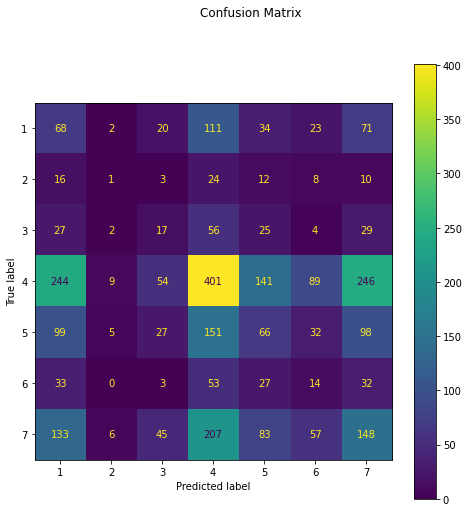

In [48]:
fig, ax = plt.subplots(figsize=(8, 8))
disp = metrics.plot_confusion_matrix(grid_imba, list(test_hist_array), y_test, values_format = 'd', ax=ax)
disp.figure_.suptitle("Confusion Matrix")
plt.show()

In [49]:
matthews_corrcoef(y_test, predicted_svm)

0.016399197569566617